# A replication of the following EDA:

## "New data allows an initial look at ride hailing in Chicago"  
https://www.cmap.illinois.gov/updates/all/-/asset_publisher/UIMfSLnFfMB6/content/new-data-allows-an-initial-look-at-ride-hailing-in-chicago

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import seaborn as sb
import bokeh, bokeh.plotting, bokeh.models
from bokeh.io import output_notebook, show
output_notebook()
import urllib
import dask.dataframe as dd
import dask.distributed 


Loading BokehJS ...

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:58274 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


In [3]:
#read in Chicago census tract shapefile
census = gpd.read_file('census2010/census2010.shp')

In [4]:
tnc = dd.read_csv("TNC_trips_small.csv", blocksize=25e6)
print("There are {} partitions. ".format(tnc.npartitions))

There are 12 partitions. 


In [5]:
#rename columns to change " " to "_" and lower capital letters
tnc.columns = map(str.lower, tnc.columns)
tnc.columns = tnc.columns.str.replace(' ', '_')

In [6]:
#slice tnc data
#keep only what we need
tnc_sliced = tnc[['trip_id','trip_start_timestamp','trip_end_timestamp',
                  'trip_miles','trip_seconds','pickup_census_tract', 
                  'dropoff_census_tract','fare', 'tip','additional_charges',
                  'trip_total','shared_trip_authorized','trips_pooled']]
# drop unnamed:_0 because it looks like a repetitive index column
tnc.drop('unnamed:_0', axis=1)
tnc.shape

(Delayed('int-320687b2-f913-449a-89c0-96fb5ddba8ed'), 22)

In [7]:
tnc_sliced = tnc_sliced.dropna()

In [8]:
tnc_sliced.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 13 entries, trip_id to trips_pooled
dtypes: object(3), bool(1), float64(8), int64(1)

In [9]:
tnc_sliced.dropna()
tnc.shape

(Delayed('int-24b3f450-7123-40d2-8106-1407fe0499d1'), 22)

#### Number of trips by Census Tract Heatmap

In [10]:
#change from str to integers
tnc_sliced.pickup_census_tract = tnc_sliced.pickup_census_tract.astype(int)
tnc_sliced.dropoff_census_tract = tnc_sliced.dropoff_census_tract.astype(int)
#change from integers to strings
tnc_sliced.pickup_census_tract = tnc_sliced.pickup_census_tract.astype(str)
tnc_sliced.dropoff_census_tract = tnc_sliced.dropoff_census_tract.astype(str)
tnc_sliced.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 13 entries, trip_id to trips_pooled
dtypes: object(5), bool(1), float64(6), int64(1)

In [10]:
counts = tnc_sliced.groupby('pickup_census_tract').count().compute()

In [11]:
#merge pickup census tract with census tract shapefile
merged_p = counts.merge(census, left_on='pickup_census_tract', 
                        right_on = 'geoid10', how='left')
merged_p = gpd.GeoDataFrame(merged_p)

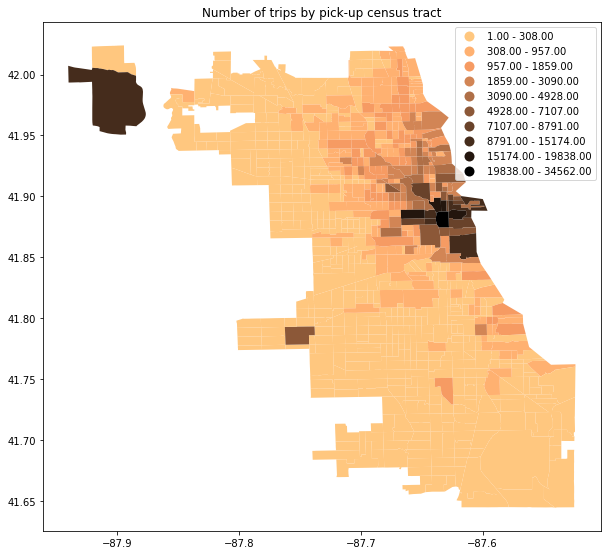

In [12]:
merged_p.plot(column="trip_id", cmap="copper_r", 
              scheme="fisher_jenks", k=10, alpha=1, figsize=(10,10),
              legend=True)
plt.title("Number of trips by pick-up census tract");

#### Number of trips citywide by time of day for each day of the week.

In [13]:
tnc_sliced[['trip_id','trip_start_timestamp','trip_end_timestamp']].head(5)

,trip_id,trip_start_timestamp,trip_end_timestamp
0,c7b547c1a9f083f80e3d1e86e01da3608c3f30ba,03/21/2019 03:45:00 PM,03/21/2019 05:00:00 PM
1,c7b549668b81eee3e0ffa418736929ffc16a7b39,03/06/2019 05:00:00 PM,03/06/2019 05:15:00 PM
2,c7b54a83387eb3ddc8e396fd7762162aa2f4865e,11/25/2018 05:45:00 PM,11/25/2018 05:45:00 PM
3,c7b54afe4faed0b4246b1ba6f58b3db68a6fb320,11/09/2018 07:15:00 PM,11/09/2018 07:30:00 PM
4,c7b54b73c947d1c9942f60d4e7fa1cbfe04d5a32,01/06/2019 02:15:00 AM,01/06/2019 02:30:00 AM


In [11]:
#convert to datetime
tnc_sliced.trip_start_timestamp = tnc_sliced.trip_start_timestamp.astype('datetime64[ns]')

In [12]:
#convert to datetime
tnc_sliced.trip_end_timestamp = tnc_sliced.trip_end_timestamp.astype('datetime64[ns]') 

In [13]:
#create a new column for week day (according to start time of the trip)
tnc_sliced['start_week_day'] = tnc_sliced.trip_start_timestamp.dt.dayofweek 

In [14]:
#create a new column for  start hour (according to start time of the trip)
tnc_sliced['start_hour'] = tnc_sliced.trip_start_timestamp.dt.hour

In [15]:
#replace day values with strings
d = {0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday",4:"Friday",5:"Saturday", 6:"Sunday"}
#tnc_sliced.start_week_day.replace(to_replace=d)
tnc_sliced.start_week_day.mask(tnc_sliced.start_week_day == 0, "Monday")
tnc_sliced.start_week_day.mask(tnc_sliced.start_week_day == 1, "Tuesday")
tnc_sliced.start_week_day.mask(tnc_sliced.start_week_day == 2, "Wednesday")
tnc_sliced.start_week_day.mask(tnc_sliced.start_week_day == 3, "Thursday")
tnc_sliced.start_week_day.mask(tnc_sliced.start_week_day == 4, "Friday")
tnc_sliced.start_week_day.mask(tnc_sliced.start_week_day == 5, "Saturday")
tnc_sliced.start_week_day.mask(tnc_sliced.start_week_day == 6, "Sunday")

Dask Series Structure:
npartitions=12
    object
       ...
     ...  
       ...
       ...
Name: start_week_day, dtype: object
Dask Name: replace, 396 tasks

In [17]:
grouped = tnc_sliced.groupby(['start_week_day', 'start_hour']).count().compute()['trip_id']

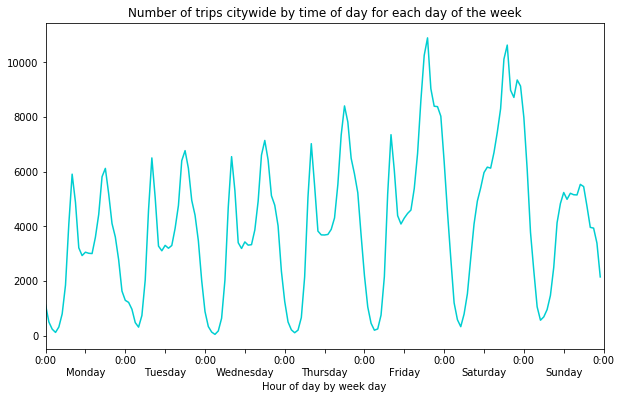

In [36]:
fig = grouped.plot(color='darkturquoise', figsize=(10,6))
plt.xticks(np.arange(0,169,12))
plt.xlabel("Hour of day by week day")
plt.title("Number of trips citywide by time of day for each day of the week")
labels = ["0:00",'\n'+'Monday',"0:00", '\n'+'Tuesday',"0:00", '\n'+'Wednesday',"0:00", '\n'+'Thursday', 
          "0:00",'\n'+'Friday', "0:00",'\n'+'Saturday',"0:00", '\n'+'Sunday', "0:00"]
fig.set_xticklabels(labels);

#### Citywide TNC usage peaks during congested commute periods 
(Miles per hour & trips per hour against time of day)

In [26]:
#drop the trips with trip_seconds == 0
tnc_sliced = tnc_sliced.query('trip_seconds != 0')

In [27]:
#calculate miles per hour
tnc_sliced['speed'] = tnc_sliced['trip_miles']/tnc_sliced['trip_seconds']*60*60

In [34]:
#average speed by hour of day
grouped_speed = tnc_sliced.groupby(['start_hour']).mean().compute()['speed']

In [36]:
#total trips per hour
grouped_trip = tnc_sliced.groupby(['start_hour']).count().compute()['trip_id']

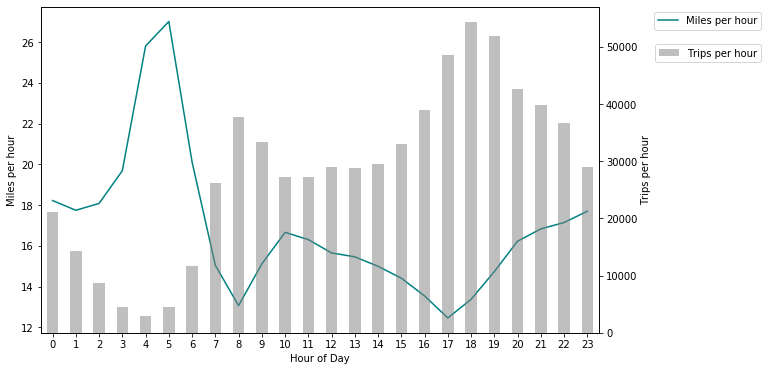

In [78]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(grouped_speed, color='teal')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Miles per hour')
ax.legend(['Miles per hour'], bbox_to_anchor=(1.3, 1.0))
ax_twin = ax.twinx() 
grouped_trip.plot.bar(color='gray', alpha=0.5)
ax_twin.set_ylabel('Trips per hour')
ax_twin.legend(['Trips per hour'], bbox_to_anchor=(1.3, 0.9));

#### Percent of trips shared and trips per hour by EDA (economically disconnected areas)

In [18]:
#read in economically disconnected areas data
edas = pd.read_csv('edas.csv')
edas = edas[['side','GEOID10']]
edas.GEOID10 = edas.GEOID10.astype(str)
#merge tnc data with data on economically disconnected areas (by census tract ID)
tnc_edas = tnc_sliced.merge(edas, left_on='pickup_census_tract', right_on = 'GEOID10', how='left')

In [19]:
#fill missing values with "non-EDA"
tnc_edas.side = tnc_edas.side.fillna('non-EDA')

In [20]:
noneda = tnc_edas.query('side=="non-EDA"')
north = tnc_edas.query('side=="North/Northwest"')
south = tnc_edas.query('side=="South/Southwest"')
west = tnc_edas.query('side=="West"')

In [101]:
#calculate North percent of shared rides authorized
grouped_north = north.groupby('start_hour')['shared_trip_authorized'].sum().compute()/north.groupby('start_hour')['shared_trip_authorized'].count().compute()
#calculate Non-EDA percent of shared rides authorized
grouped_noneda = noneda.groupby('start_hour')['shared_trip_authorized'].sum().compute()/noneda.groupby('start_hour')['shared_trip_authorized'].count().compute()
#calcualte South percent of shared rides authorized
grouped_south = south.groupby('start_hour')['shared_trip_authorized'].sum().compute()/south.groupby('start_hour')['shared_trip_authorized'].count().compute()
#calculate West percent of shared rides authorized
grouped_west = west.groupby('start_hour')['shared_trip_authorized'].sum().compute()/west.groupby('start_hour')['shared_trip_authorized'].count().compute()

In [ ]:
fig, ax= plt.subplots(figsize=(10,6))
ax.plot(grouped_north, color='lightcoral')
#ax.plot(grouped_south, color='purple')
#ax.plot(grouped_west, color='skyblue')
#ax.plot(grouped_noneda, color='orange')
ax.legend(['Trips starting from North/Northwest EDAs',
           'Trips starting from South/Southwest EDAs',
           'Trips starting from West EDAs',
           'Trips starting from non-EDAs'], bbox_to_anchor=(1.1,1))
ax.set_xlabel('Hour of day')
ax.set_ylabel('Percent of trips shared')
ax_twin = ax.twinx() 
grouped_trip.plot.bar(color='gray', alpha=0.5)
ax_twin.set_ylabel('Trips per hour')
ax_twin.legend(['Total Trips']);